## NN Fundamentals keras

Vamos a ver los fundamentos de las Redes Nueronales.

In [104]:
# Importación de librerias
import tensorflow as tf # importación de la libreria de deep learning tensorflow
from tensorflow import keras # Importación de la API de alto nivel para definir, entrenar, evaluar y guardar modelos de deep learning
from tensorflow.keras import layers #es el submódulo de Keras que reúne todas las capas que usas para construir redes neuronales.Cada capa es un bloque que transforma tensores (entrada → salida) y puede tener pesos entrenables.

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt

tf.random.set_seed(0)

In [105]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.05
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

### Dataset

Tenemos un dataset con una clasificación binaria. El targey (y) tiene dos posibles valores (0,1) y el vector de input (X) tiene dos dimensiones

In [106]:
N = 5000 # Definimos el mumero de muestras que queremos en nuestro dataset sintético
X, y = load_planar_dataset(N, 0.2) # Genera un dataset planar (2D) con 5.000 puntos y 0.2 de nivel de ruido (dispersión/solapamiento entre clases)

Visualizamos el dataset usando matplotlib. El dataset se ve como una flor con puntos rojos (label y=0) y con puntos azules (y=1). El objetivo es construir un modelo para entrenar esos datos.

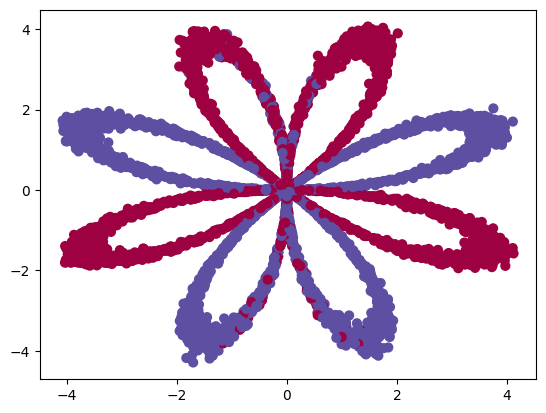

In [107]:
# Visualización de los datos
plt.scatter(X[:,0],X[:,1], c=y.ravel(),s=40, cmap=plt.cm.Spectral);

In [108]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X , y, test_size=0.2
)

In [109]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [110]:
## X primer ejemplo
X[0,:]

array([-3.19587215,  1.72717564])

In [111]:
## Y primer ejemplo
y[:8]

array([1, 0, 0, 0, 1, 0, 1, 0], dtype=uint8)

### Primera NN en Keras

Regresión Logistica:

Las capas totalmente conectadas se definen usando la clase Dense (Capas Densas: conexión de todas parámetros). Podemos especificar el número de neuronas como primer argumento y la función de activación mediante el argument `activation`.

```python
tf.keras.layers.Dense(
    units, activation=None
)
```

*   units: número de neuronas de la capa
*   activation: Función de activación a usar; por defecto es `linear` (lineal). también puede usar `sigmoid` para activación sigmoide (no lineal).  


Para definir la capa de entrada se puede usar `keras.Input(shape(input_dimension,))` o definir la dimension de entrada en la primera capa oculta.

``` python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))
```

Construye una red sin capa oculta.



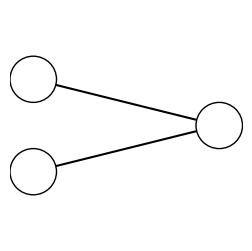

In [112]:
draw_neural_net (.1,.9,.1,.9,[2,1])  # Simplemente ilustra el tipo de red

In [113]:
model = keras.Sequential() # Creación de un modelo secuencial, es un contenedor para apilar capas en orden lineal (una detrás de otra)
# La dimensión del iout es 2 (datos planares)
# Solo tenemos un parámetro de ouput con 1 neurona
model.add(keras.layers.Dense(1, input_shape=(2,), activation='sigmoid'))

In [114]:
model.summary() # muestra un resumen de la red en Keras

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

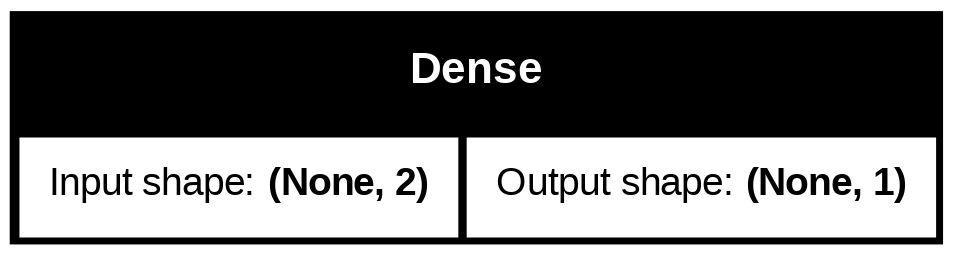

In [115]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

#### Compilación

Ahora necesitamos especificar la function de perdida (loss function), las metricas y el optimizador. Se hace mediante la función `compile()` en keras

In [116]:
# Necesario para que quede listo para entrenar indicando como debe aprender y qué evaluar.
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = ['accuracy', 'precision']
)

#### Training model

Similar a sklearn model

In [117]:
model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3703 - loss: 0.8897 - precision: 0.3864 - val_accuracy: 0.4175 - val_loss: 0.8104 - val_precision: 0.4429
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3922 - loss: 0.8238 - precision: 0.4095 - val_accuracy: 0.4387 - val_loss: 0.7656 - val_precision: 0.4668
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4213 - loss: 0.7735 - precision: 0.4390 - val_accuracy: 0.4675 - val_loss: 0.7335 - val_precision: 0.4974
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4537 - loss: 0.7371 - precision: 0.4723 - val_accuracy: 0.5050 - val_loss: 0.7112 - val_precision: 0.5365
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5035 - loss: 0.7113 - precision: 0.5212 - val_accuracy: 0.4100 - val_loss: 0.6961 - val_precision: 0.4406
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4762 - loss: 0.6934 - precision: 0.4916 - val_accuracy: 0.5925 - val_loss:

#### Haciendo predicciones

In [118]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
print('Test Precision: {}'.format(results[2]))

Test Loss: 0.6644547581672668
Test Accuracy: 0.515999972820282
Test Precision: 0.4938524663448334


In [119]:
print(results)

[0.6644547581672668, 0.515999972820282, 0.4938524663448334]


In [120]:
y_pred = model.predict(X_test)
y_pred[:3], y_test[:3]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(array([[0.5865776 ],
        [0.54601574],
        [0.55900705]], dtype=float32),
 array([0, 0, 0], dtype=uint8))

1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


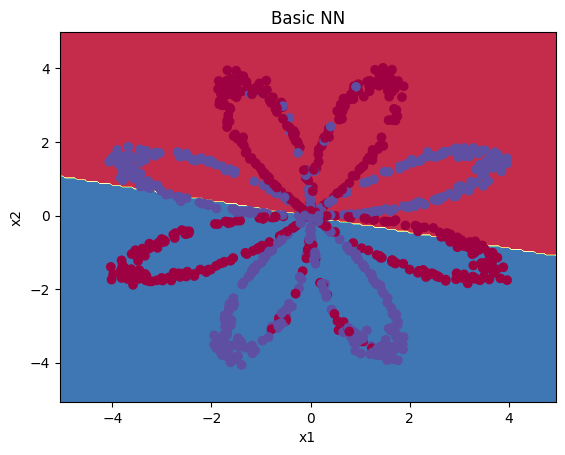

In [121]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN"); # ploteamos la curva de decision de nuestro modelo simple de NN

Encontramos un modelo bastante simple que nos clasifica los punts como si fuera una regresión logistica. Para mejorarlo debemos añadirle complejidad, y para ello, añadiremos más capas a nuestro modelo.

### Red neuronal con una capa oculta

* Una entrada con 2 características (`input_shape`)
* Una capa densa oculta, con 3 neuronas y función de activación sigmoide.
* Una salida (con función de activación sigmoide)

Podemos crear las capas de forma incremental con el método `add()`:

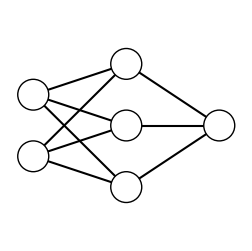

In [122]:
draw_neural_net(.1,.9,.1,.9,[2,3,1]) # Simplemente ilustra el tipo de red

In [123]:
model = keras.Sequential()
# capa oculta de 3 neuronas y activation =sigmoid
# La primera capa necesita tener el input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='sigmoid'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

# model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

Podemos tabíen definir el modelo con una lista d capas

In [124]:
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])

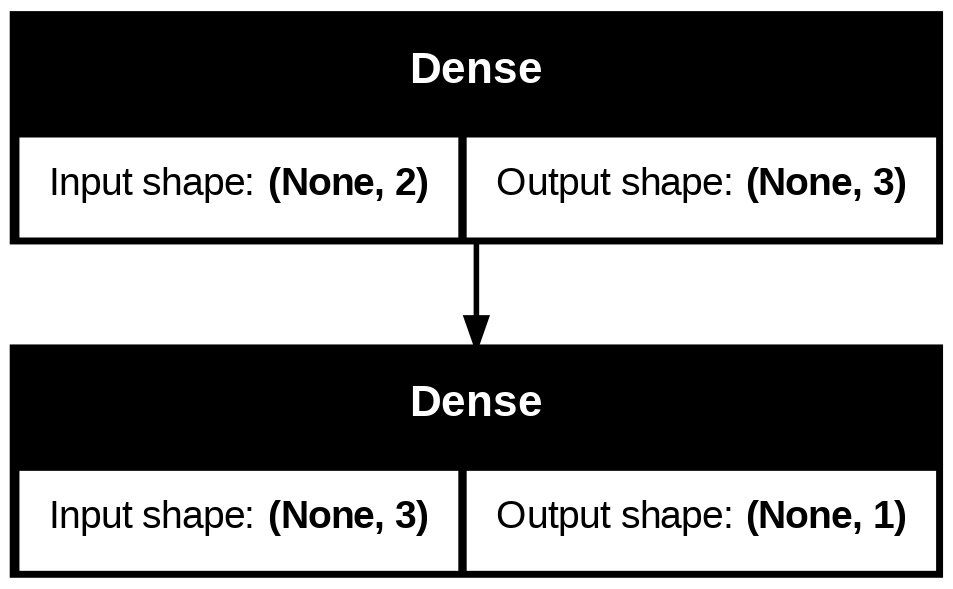

In [125]:
plot_model(model, show_shapes=True)

In [126]:
## Compilación y entrenamiento
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4776 - loss: 0.8344 - val_accuracy: 0.4500 - val_loss: 0.7922
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4243 - loss: 0.7852 - val_accuracy: 0.3913 - val_loss: 0.7555
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3812 - loss: 0.7525 - val_accuracy: 0.3800 - val_loss: 0.7322
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3694 - loss: 0.7307 - val_accuracy: 0.3988 - val_loss: 0.7169
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4330 - loss: 0.7155 - val_accuracy: 0.4700 - val_loss: 0.7062
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4816 - loss: 0.7041 - val_accuracy: 0.4700 - val_loss: 0.6984
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4647 - loss: 0.6954 - val_accuracy: 0.4363 - val_loss: 0.6925
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4943 - loss: 0.6886 - val_accuracy: 0.

In [127]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6438685655593872
Test Accuracy: 0.5619999766349792


1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


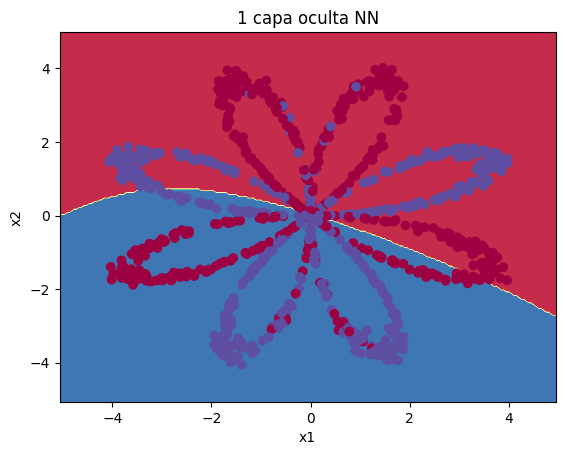

In [128]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

### Pregunta 1: Que passa si cambiamos la activation function para la primera capa oculta a `linear`?

In [129]:
model = keras.Sequential()
# capa oculta de 3 neuronas
# La primera capa necesita tener el input_shape
model.add(layers.Dense(3, input_shape=(2,), activation='linear'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [130]:
# Compilación y entreno
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3929 - loss: 1.1819 - val_accuracy: 0.4512 - val_loss: 0.9217
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4586 - loss: 0.9059 - val_accuracy: 0.5013 - val_loss: 0.7613
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5191 - loss: 0.7446 - val_accuracy: 0.6650 - val_loss: 0.6916
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6789 - loss: 0.6782 - val_accuracy: 0.5337 - val_loss: 0.6733
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5354 - loss: 0.6605 - val_accuracy: 0.4512 - val_loss: 0.6702
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4773 - loss: 0.6570 - val_accuracy: 0.4475 - val_loss: 0.6701
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4711 - loss: 0.6567 - val_accuracy: 0.4525 - val_loss: 0.6703
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4792 - loss: 0.6570 - val_accuracy: 0.

In [131]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.6609475612640381
Test Accuracy: 0.5040000081062317


1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


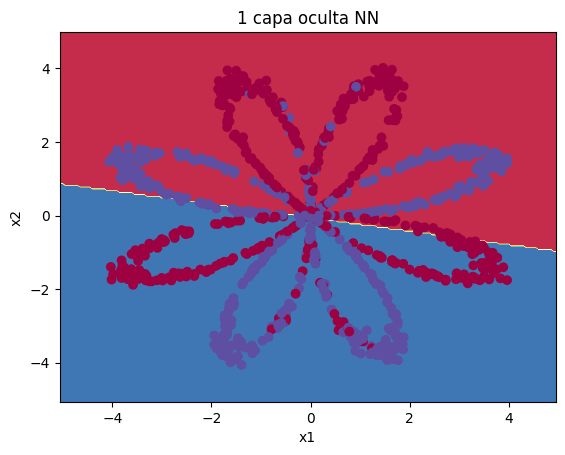

In [132]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

Al usar `linear` como activation en vez de `sgimoide` en la capa oculta, baja el rendimiento de nuestro modelo y vuelve a realizar una predicción lineal.

### Pregunta 2: Que pasa si añadimos mas neuronas a la primera capa oculta

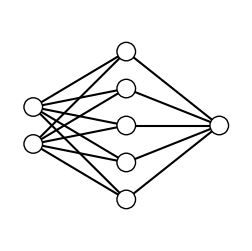

In [133]:
draw_neural_net(.1,.9,.1,.9,[2,5,1])

In [134]:
model = keras.Sequential()
# capa oculta de 3 neuronas
# La primera capa necesita tener el input_shape
model.add(layers.Dense(20, input_shape=(2,), activation='sigmoid'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [135]:
# Compilación y entreno
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4838 - loss: 0.7321 - val_accuracy: 0.5400 - val_loss: 0.6828
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5364 - loss: 0.6724 - val_accuracy: 0.4888 - val_loss: 0.6715
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4991 - loss: 0.6600 - val_accuracy: 0.4762 - val_loss: 0.6668
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4927 - loss: 0.6538 - val_accuracy: 0.4750 - val_loss: 0.6632
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4928 - loss: 0.6490 - val_accuracy: 0.4762 - val_loss: 0.6595
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4919 - loss: 0.6445 - val_accuracy: 0.4812 - val_loss: 0.6555
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4927 - loss: 0.6399 - val_accuracy: 0.4875 - val_loss: 0.6511
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4955 - loss: 0.6349 - val_accuracy: 0.

In [136]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.466498464345932
Test Accuracy: 0.8519999980926514


1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


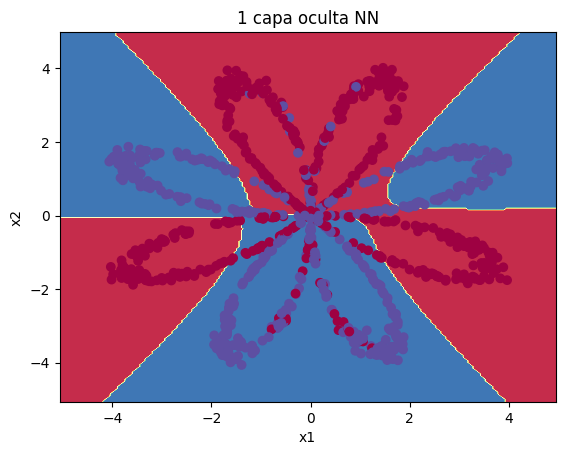

In [137]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

### Pregunta 3: Que pasa si le añadimos otra capa oculta?

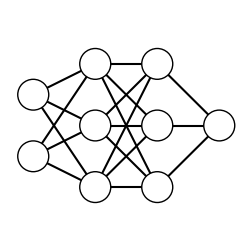

In [138]:
draw_neural_net(.1,.9,.1,.9,[2,3,3,1])

In [139]:
model = keras.Sequential()
# capa oculta de 3 neuronas
model.add(layers.Dense(20, input_shape=(2,), activation='sigmoid'))

# Segunda capa oculta de 3 neuronas
model.add(layers.Dense(12, activation='sigmoid'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [140]:
# Compilación y entreno
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4932 - loss: 0.6918 - val_accuracy: 0.5375 - val_loss: 0.6867
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5617 - loss: 0.6792 - val_accuracy: 0.5263 - val_loss: 0.6781
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5352 - loss: 0.6681 - val_accuracy: 0.5138 - val_loss: 0.6710
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5232 - loss: 0.6585 - val_accuracy: 0.5113 - val_loss: 0.6639
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5253 - loss: 0.6492 - val_accuracy: 0.5100 - val_loss: 0.6564
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5318 - loss: 0.6398 - val_accuracy: 0.5100 - val_loss: 0.6486
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5380 - loss: 0.6300 - val_accuracy: 0.5125 - val_loss: 0.6405
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5446 - loss: 0.6203 - val_accuracy: 0.

In [141]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.3273184895515442
Test Accuracy: 0.890999972820282


1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


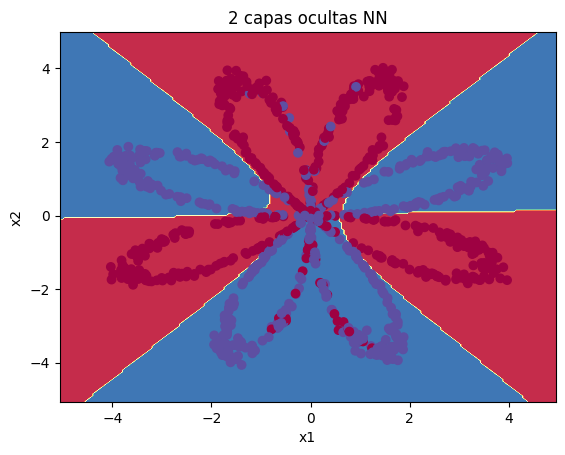

In [142]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("2 capas ocultas NN"); # representación gráfica

Usamos la función de activación hiperbólica `tanh` con el primer modelo y la comparamos con la activation `sigmoid`

In [143]:
model = keras.Sequential()
# capa oculta de 3 neuronas y activation =tanh
model.add(layers.Dense(3, input_shape=(2,), activation='tanh'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [144]:
# Compilación y entreno
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3592 - loss: 0.8706 - val_accuracy: 0.4225 - val_loss: 0.7722
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4162 - loss: 0.7557 - val_accuracy: 0.4688 - val_loss: 0.7029
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4952 - loss: 0.6895 - val_accuracy: 0.5688 - val_loss: 0.6659
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6004 - loss: 0.6538 - val_accuracy: 0.6237 - val_loss: 0.6458
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6550 - loss: 0.6337 - val_accuracy: 0.6350 - val_loss: 0.6335
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6642 - loss: 0.6209 - val_accuracy: 0.6375 - val_loss: 0.6244
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6653 - loss: 0.6112 - val_accuracy: 0.6400 - val_loss: 0.6165
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6701 - loss: 0.6030 - val_accuracy: 0.

In [145]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.40509334206581116
Test Accuracy: 0.8830000162124634


1269/1269 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


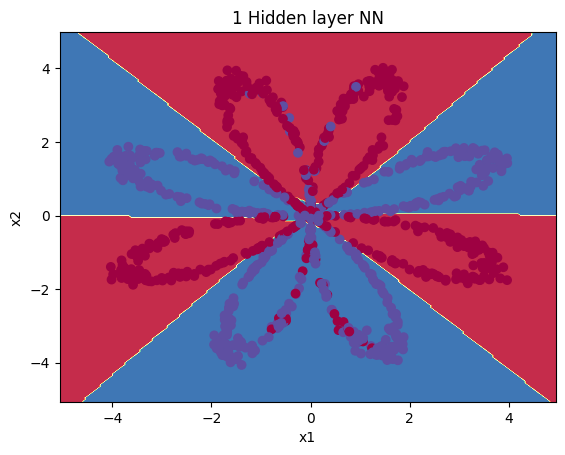

In [146]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN"); # representación gráfica

### Practica 1

Vamos a repetir el proceso con un dataset distinto

In [147]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise = 0.18)

In [148]:
X.shape

(5000, 2)

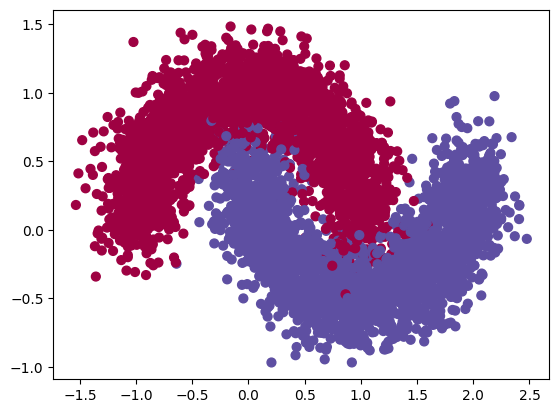

In [149]:
# Visualización de los datos:

plt.scatter(X[:,0],X[:,1], c=y.ravel(),s=40, cmap=plt.cm.Spectral);

In [150]:
# Train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X , y, test_size=0.2
)

print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))


X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


#### Definición del modelo

In [151]:
model = keras.Sequential()
# capa oculta de 3 neuronas
model.add(layers.Dense(20, input_shape=(2,), activation='linear'))
model.add(layers.Dense(20, activation='linear'))
model.add(layers.Dense(20, activation='linear'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [152]:
# Compilación y entrenamiento
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=32)

Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6991 - loss: 0.5389 - val_accuracy: 0.8625 - val_loss: 0.2993
Epoch 2/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8575 - loss: 0.2988 - val_accuracy: 0.8825 - val_loss: 0.2722
Epoch 3/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8662 - loss: 0.2893 - val_accuracy: 0.8838 - val_loss: 0.2713
Epoch 4/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8667 - loss: 0.2892 - val_accuracy: 0.8838 - val_loss: 0.2712
Epoch 5/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8672 - loss: 0.2891 - val_accuracy: 0.8838 - val_loss: 0.2713
Epoch 6/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8674 - loss: 0.2891 - val_accuracy: 0.8825 - val_loss: 0.2713
Epoch 7/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8674 - loss: 0.2892 - val_accuracy: 0.8825 - val_loss: 0.2713
Epoch 8/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8674 - loss: 0.2892 - val_accuracy: 0.

In [153]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.2669179141521454
Test Accuracy: 0.8830000162124634


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


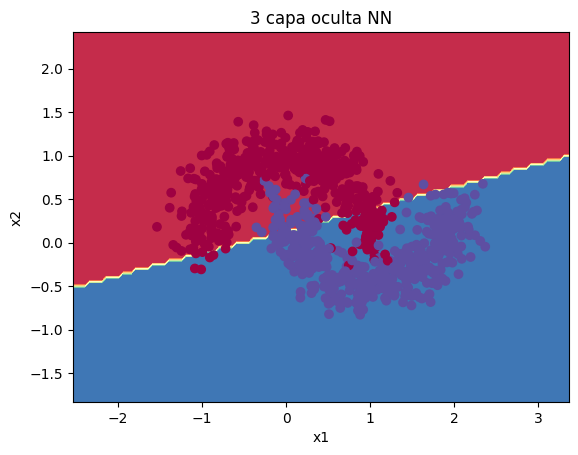

In [154]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("3 capa oculta NN"); # representación gráfica

### Guardar y cargar Moldeos eras

Es posible guardar los modelos enteros en una simple call usando los formatos `.keras` o `.h5.`.

* `.keras` : El formato recomendable de TensrFlow
* `.h5.`: Un formato mas antiguo

In [155]:
import datetime

# Guardar el modelo con timestamp
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_name_keras= f"keras_model_{current_time}.keras"
model_name_h5= f"keras_model_{current_time}.h5"

# Guardar en formato .keras
model.save(model_name_keras)

# Guardar en formato .h5
model.save(model_name_h5)

print(f"Models saved as:{model_name_keras} and {model_name_h5}" )

Models saved as:keras_model_20251015-083532.keras and keras_model_20251015-083532.h5


In [156]:
# lista de documentos en el directorio
!ls -l

total 244
-rw-r--r-- 1 root root 47936 Oct 15 08:28 keras_model_20251015-082847.h5
-rw-r--r-- 1 root root 41344 Oct 15 08:28 keras_model_20251015-082847.keras
-rw-r--r-- 1 root root 47936 Oct 15 08:35 keras_model_20251015-083532.h5
-rw-r--r-- 1 root root 41346 Oct 15 08:35 keras_model_20251015-083532.keras
-rw-r--r-- 1 root root 21874 Oct 15 08:28 Modelito_19.keras
-rw-r--r-- 1 root root 30749 Oct 15 08:34 model.png
drwxr-xr-x 1 root root  4096 Oct 13 13:43 sample_data


In [157]:
from tensorflow.keras.models import load_model

# Cargar el modelo previo
loaded_model = load_model(model_name_keras)

# Evaluación del modelo cargado
loss, accuracy = loaded_model.evaluate(X_test,y_test)
print(f"Loaded model accuracy: {accuracy*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8836 - loss: 0.2570  
Loaded model accuracy: 88.30%


### Pregunta 4: Entrena 10 epochs, guarda el model, cargarlo, y luego entrena 10 epochs mas.

In [158]:
model = keras.Sequential()
# capa oculta de 3 neuronas
model.add(layers.Dense(20, input_shape=(2,), activation='linear'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

In [159]:
# Compilación y entrenamiento
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6103 - loss: 0.6587 - val_accuracy: 0.6850 - val_loss: 0.5186
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7183 - loss: 0.4866 - val_accuracy: 0.7700 - val_loss: 0.4221
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7745 - loss: 0.4052 - val_accuracy: 0.8163 - val_loss: 0.3668
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8190 - loss: 0.3583 - val_accuracy: 0.8462 - val_loss: 0.3297
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8391 - loss: 0.3280 - val_accuracy: 0.8625 - val_loss: 0.3052
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3094 - val_accuracy: 0.8700 - val_loss: 0.2905
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8550 - loss: 0.2990 - val_accuracy: 0.8750 - val_loss: 0.2822
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8646 - loss: 0.2937 - val_accuracy: 0.

In [160]:
# Resultados
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.26804691553115845
Test Accuracy: 0.8820000290870667


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


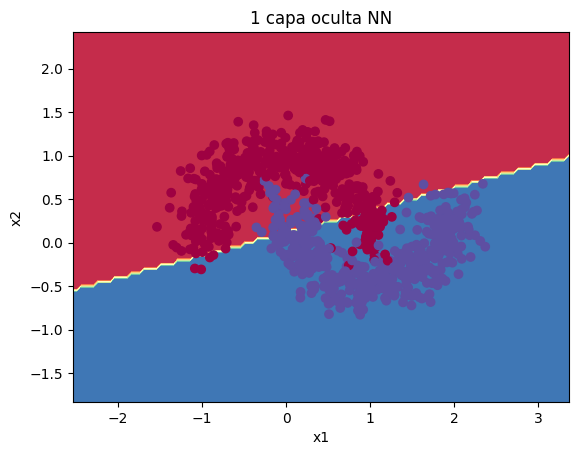

In [161]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

In [162]:
# Guardar el modelo con timestamp
model_name = "Modelito_19.keras"

# Guardar en formato .keras
model.save(model_name)

print(f"Models saved as:{model_name}" )

Models saved as:Modelito_19.keras


In [163]:
# Cargar el modelo previo
loaded_model = load_model(model_name)

In [164]:
model.fit(X_train,y_train, epochs=20, validation_split=0.2, batch_size=64)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8689 - loss: 0.2891 - val_accuracy: 0.8788 - val_loss: 0.2735
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8688 - loss: 0.2888 - val_accuracy: 0.8788 - val_loss: 0.2733
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8690 - loss: 0.2887 - val_accuracy: 0.8800 - val_loss: 0.2731
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8695 - loss: 0.2887 - val_accuracy: 0.8800 - val_loss: 0.2729
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8693 - loss: 0.2886 - val_accuracy: 0.8825 - val_loss: 0.2728
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8693 - loss: 0.2886 - val_accuracy: 0.8813 - val_loss: 0.2727
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8693 - loss: 0.2886 - val_accuracy: 0.8813 - val_loss: 0.2726
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.2885 - val_accuracy: 0.8813 - val_loss:

In [165]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.2672157883644104
Test Accuracy: 0.8809999823570251


320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


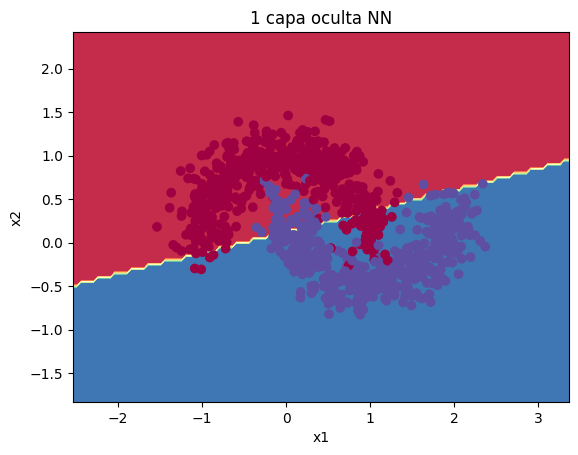

In [166]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica

### APIs funcionales

La API funcional de Keras permite definir la topología de los modelos como un grafo dirigido acíclico de las capas. A continuación, construiremos el mismo modelo que en la sección anterior, pero usando la API Funcional de Keras.

Primero debes comenzar con una entrada de datos:

```python
inputs = keras.input(shape=(8,))
```

Definimos las capas que incluiremos en la red y las relaciones entre ellas. Es importante notar que cada línea detalla el tipo de cada y sus propiedades (número de neuronas, función de activación, nombre,etc.) y, justo al final, entre paréntesis, se coloca el nombre de la variable en la que hemos guardado la capa cuya salida se conectará a la entrada de la capa que estamos declarando.

```python
layer_1 = layers.Dense(4, activation='sigmoid', name='layer_1')(inputs)

layer_2 = layers.Dense(4, activation='sigmoid', name='layer_2')(layer_1)
```

La acción de "llamar" a la capa `dense()(inuts)` es como dibujar una flecha desde `inputs` hacia la capa que acabas de crear, Estas "pasando" los datos de entrada a la capa densa, y obtienes `layer_1` como salida.

Finalmente, definimos las salidas de la red:

```python
outputs = layers.Dense(1,name='output_layer')(layer_2)
```

Creamos el modelo especificando las entradas y salidas:

```python
model = keras.model(inputs =inputs, outputs=outputs)



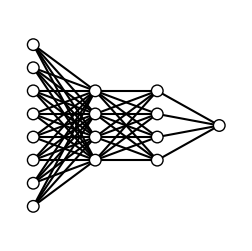

In [167]:
draw_neural_net(.1, .9, .1,.9, [8,4,4,1])

In [168]:
inputs = keras.Input(shape=(8,))
layer_1 = layers.Dense(4, activation='sigmoid', name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid', name='layer_2')(layer_1)
outputs = layers.Dense(1,name='output_layer')(layer_2)
model = keras.Model(inputs =inputs, outputs=outputs)

model.summary()

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_2 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

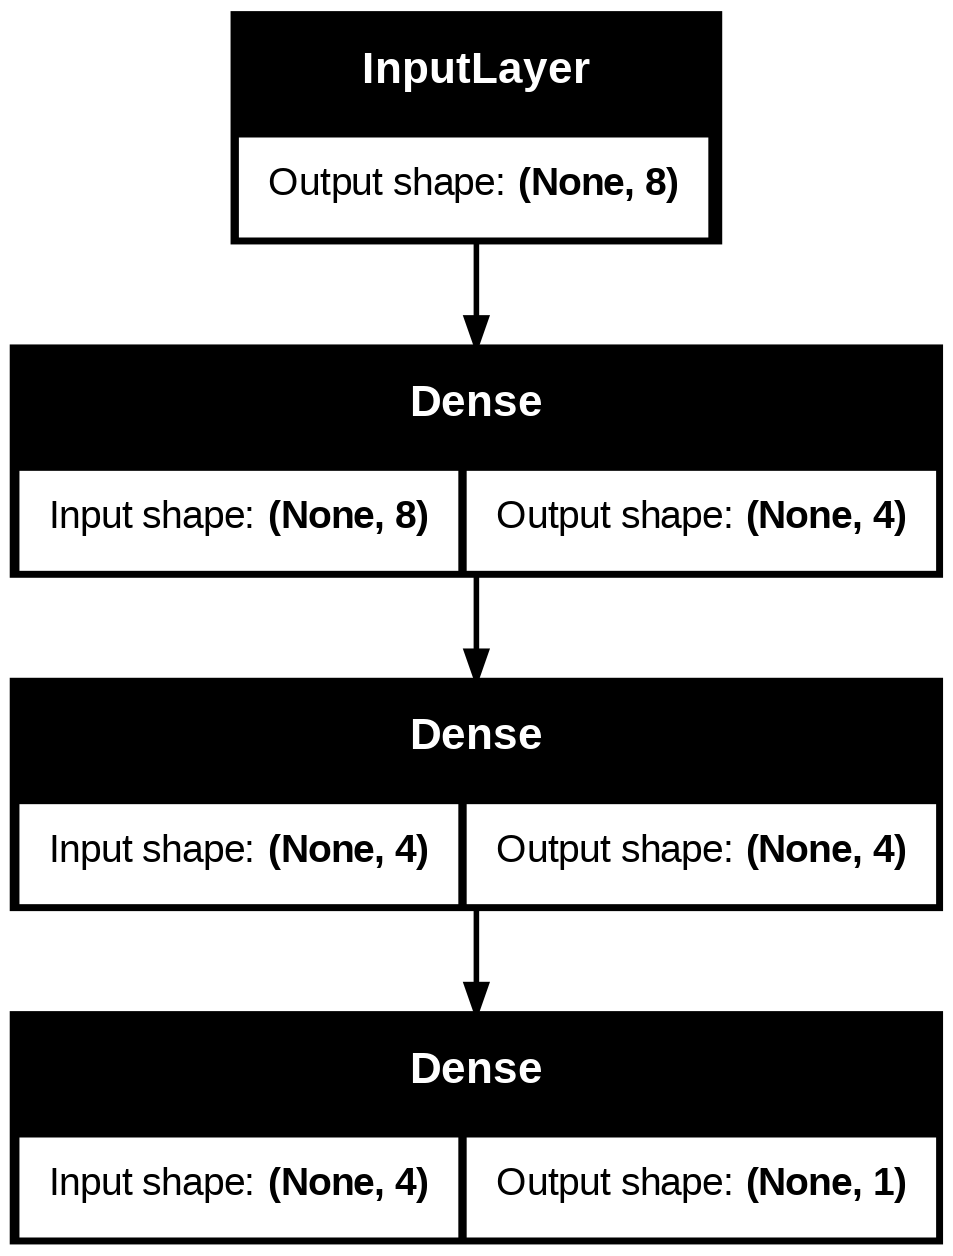

In [169]:
plot_model(model,show_shapes=True)

### Practica II

Repitamos el proceso con otro dataset


In [170]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=0.065)

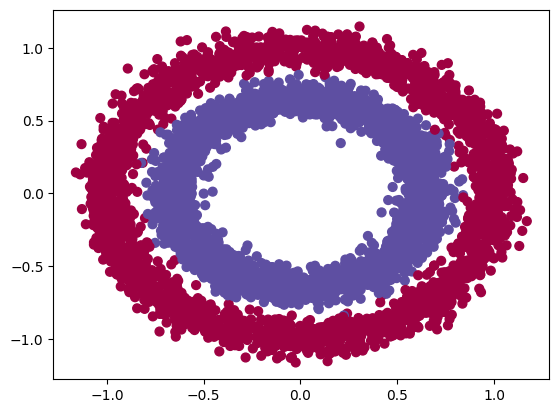

In [171]:
# Visualizamos los datos
plt.scatter(X[:,0],X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral)

In [172]:
# Train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X , y, test_size=0.2
)

print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [173]:
model = keras.Sequential()
# capa oculta de 4 neuronas
model.add(layers.Dense(4, input_shape=(2,), activation='relu'))
model.add(layers.Dense(4, activation='relu'))

# capa output
model.add(layers.Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [174]:
# Compilación y entrenamiento
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=32)

Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5151 - loss: 0.6701 - val_accuracy: 0.6125 - val_loss: 0.6632
Epoch 2/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6387 - loss: 0.6540 - val_accuracy: 0.6800 - val_loss: 0.6480
Epoch 3/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6888 - loss: 0.6402 - val_accuracy: 0.7425 - val_loss: 0.6316
Epoch 4/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7366 - loss: 0.6239 - val_accuracy: 0.7912 - val_loss: 0.6124
Epoch 5/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7853 - loss: 0.6042 - val_accuracy: 0.8250 - val_loss: 0.5899
Epoch 6/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8169 - loss: 0.5809 - val_accuracy: 0.8400 - val_loss: 0.5604
Epoch 7/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8383 - loss: 0.5500 - val_accuracy: 0.8775 - val_loss: 0.5240
Epoch 8/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8796 - loss: 0.5094 - val_accuracy: 0.

In [175]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.041629333049058914
Test Accuracy: 0.9950000047683716


229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


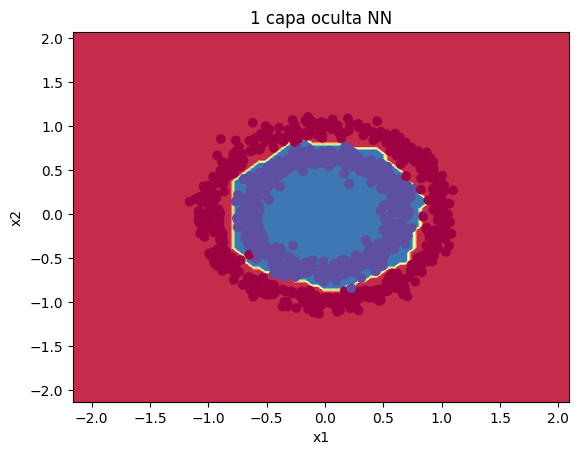

In [176]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 capa oculta NN"); # representación gráfica